In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from hmmlearn import hmm
import random

In [2]:
def visualize_mfcc(file_path1,digit1,digit2,file_path2=None,n_mfcc = 13):
    y, sr = librosa.load(file_path1, sr=None)
    mfccs1 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    y, sr = librosa.load(file_path2, sr=None)
    mfccs2 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    plt.figure(figsize=(15, 3))

    if file_path2 != None:
        plt.subplot(1,2,1)

    librosa.display.specshow(mfccs1.T, x_axis='time')
    plt.colorbar()
    plt.title(f'{digit1}')
    plt.tight_layout()

    if file_path2 is not None:
        plt.subplot(1,2,2)
        librosa.display.specshow(mfccs2.T, x_axis='time')
        plt.colorbar()
        plt.title(f'{digit2}')
        plt.tight_layout()
    plt.savefig(f'images/Visualisation/{digit1}__{digit2}')
    plt.show()
path = os.getcwd()
dataset_folder = path+'/dataset/SpokenDigit/recordings'

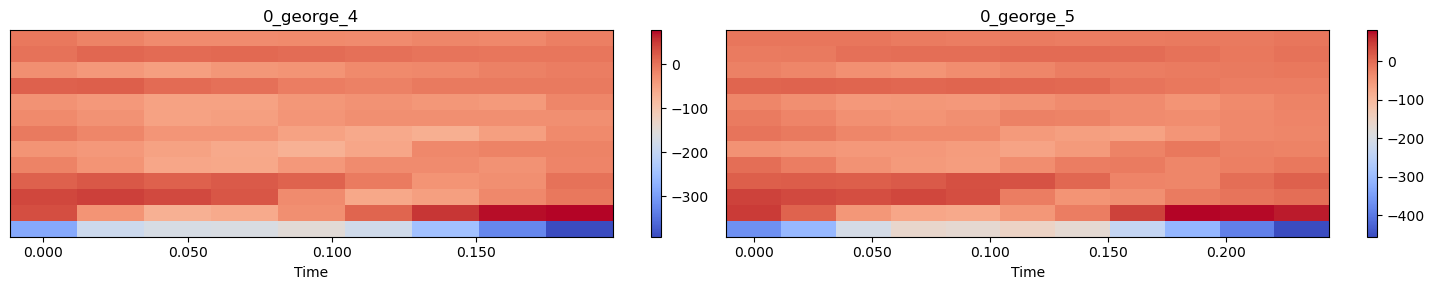

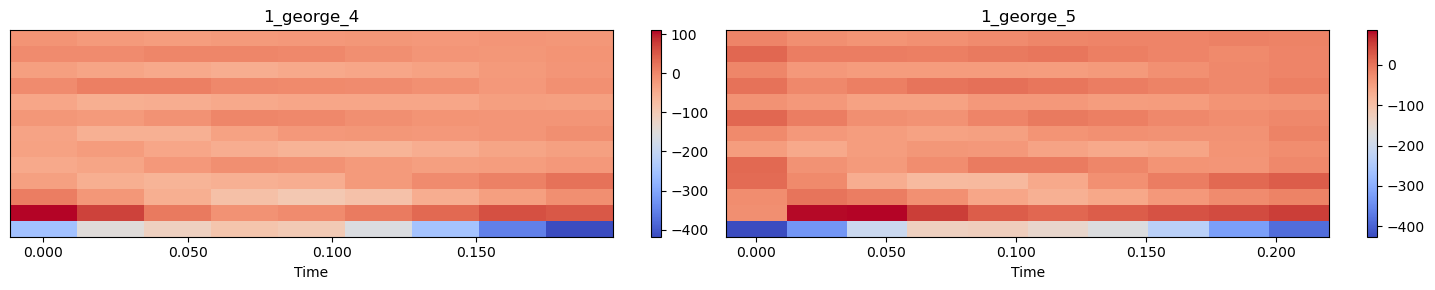

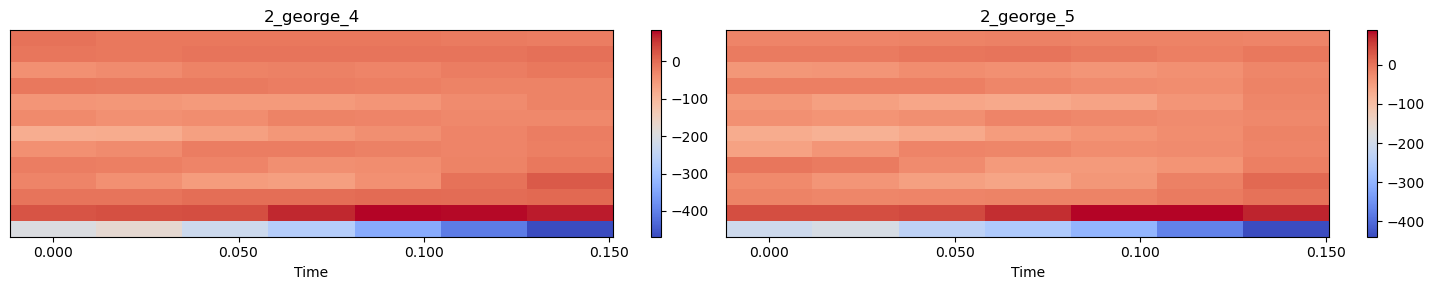

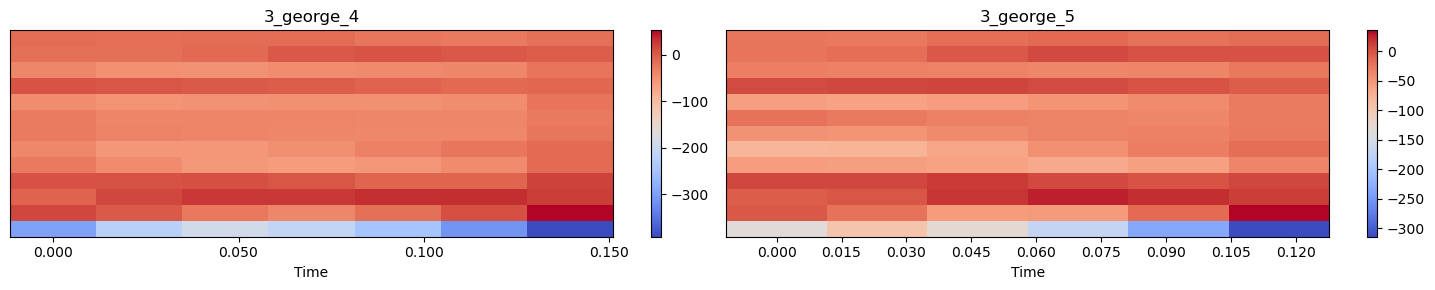

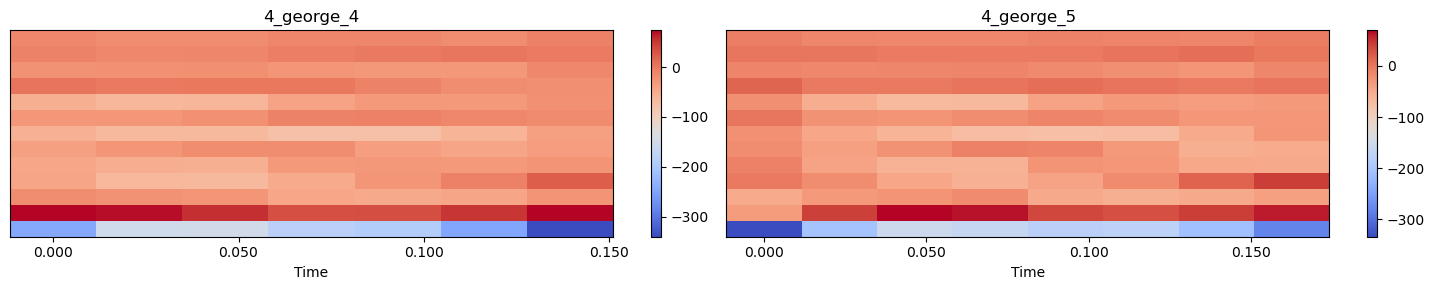

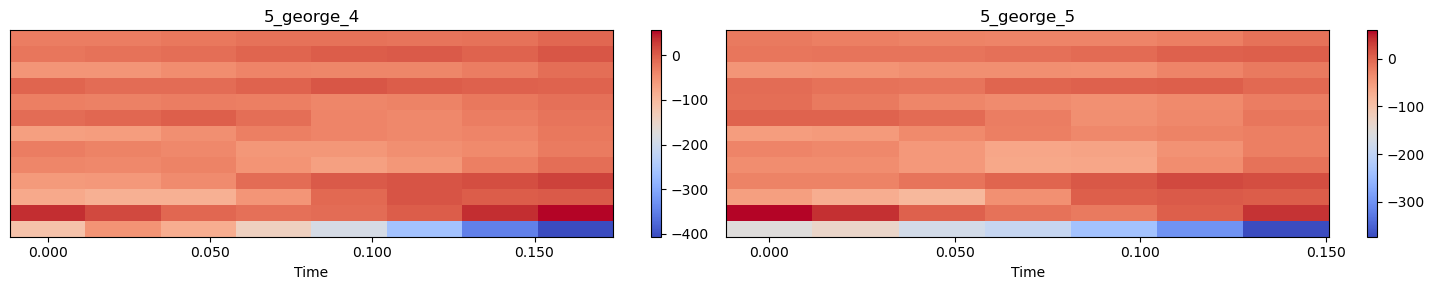

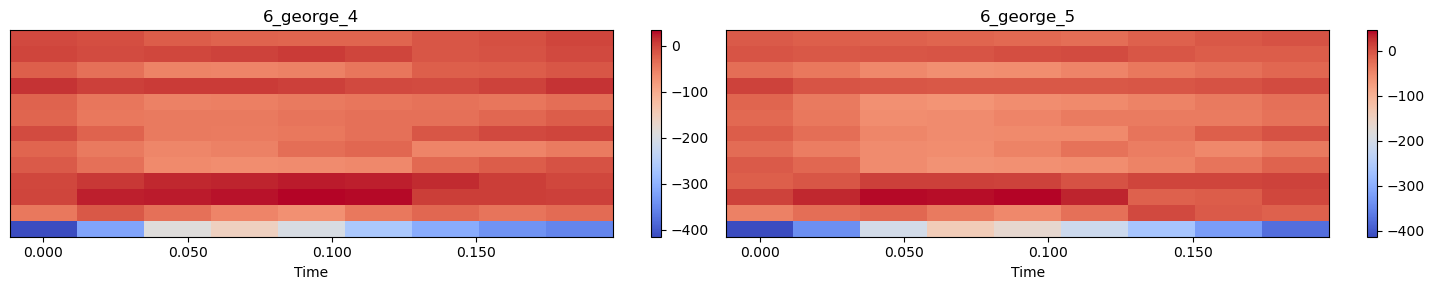

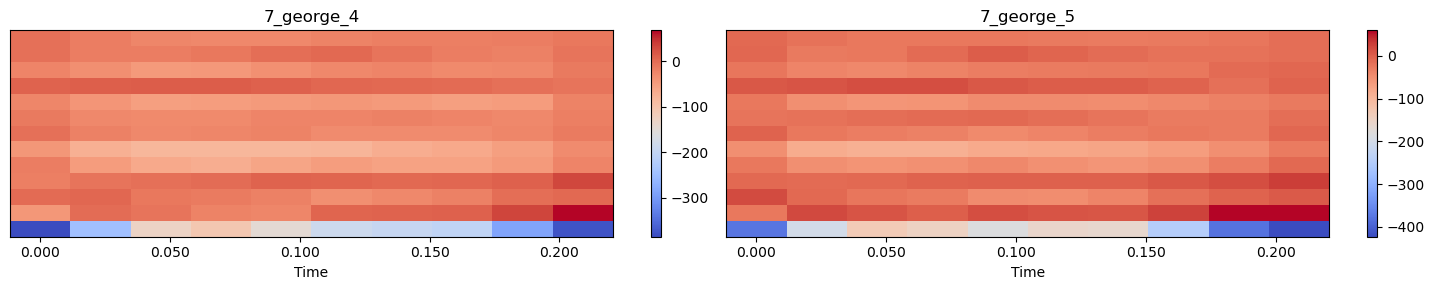

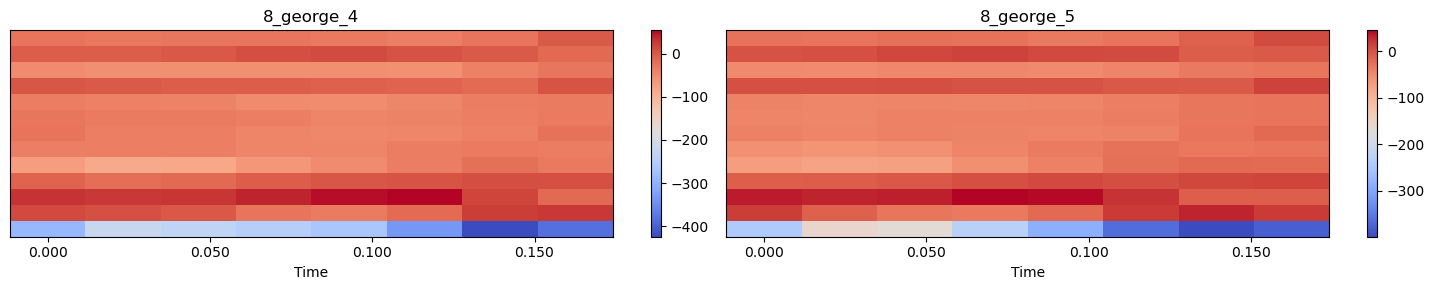

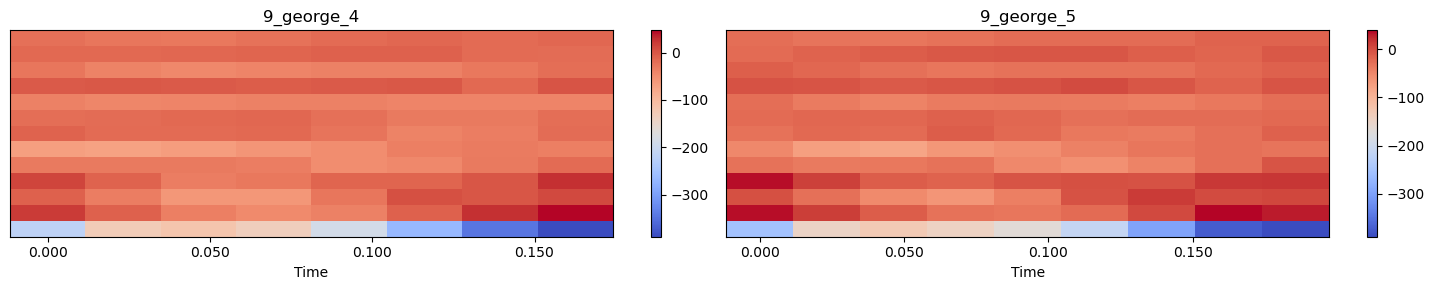

In [3]:
for i in range(10):
    digit1 = f'{i}_george_{4}'
    digit2 = f'{i}_george_{5}'
    file_path1 = dataset_folder + '/' + digit1 + '.wav'
    file_path2 = dataset_folder + '/' + digit2 + '.wav'
    visualize_mfcc(file_path1=file_path1,file_path2=file_path2,digit1=digit1,digit2=digit2,n_mfcc=13)

In [4]:
x = []
y = []
for file_name in os.listdir(dataset_folder):
    if file_name.endswith('.wav'):
        digit = int(file_name.split('_')[0])
        file_path = os.path.join(dataset_folder, file_name)
        Y, sr = librosa.load(file_path, sr=None)
        mfcc_features = librosa.feature.mfcc(y=Y, sr=sr, n_mfcc=10, n_fft = 1024).T
        x.append(mfcc_features)
        y.append(digit)

In [5]:
combined = list(zip(x, y))
random.shuffle(combined)
x, y = zip(*combined)
print(len(x))

3000


In [6]:
id1 = int(0.8*len(x))
# id2 = int(0.9*len(x))
X_train, Y_train = x[:id1], y[:id1]
# X_val, Y_val = x[id1:id2], y[id1:id2]
X_test, Y_test = x[id1:], y[id1:]

#### Training hmm models for individual digits and writing the predict logic

In [7]:
n_components = 4
n_iter = 100

models = []
for digit in range(10):
    digit_samples = [X_train[i] for i in range(len(Y_train)) if Y_train[i] == digit]

    lengths = [len(sample) for sample in digit_samples]
    X = np.concatenate(digit_samples)

    model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=n_iter)
    model.fit(X, lengths)
    models.append(model)

def predict(models, sample):
    best_likelihood = float('-inf')
    predicted_digit = None
    for i in range(10):
        log_likelihood = models[i].score(sample)
        if log_likelihood > best_likelihood:
            best_likelihood = log_likelihood
            predicted_digit = i
    
    return predicted_digit

def evaluate(models, X_test, Y_test):
    correct_predictions = 0
    total_samples = len(X_test)
    
    for i in range(total_samples):
        predicted_label = predict(models, X_test[i])
        
        if predicted_label == Y_test[i]:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_samples
    return accuracy, correct_predictions, total_samples

#### Evaluating the model on the test dataset

In [8]:
accuracy, correct, total = evaluate(models, X_test, Y_test)
print(f"Test Accuracy: {accuracy*100:.2f} ({correct}/{total})")

Test Accuracy: 90.67 (544/600)


#### Evaluating the model on personal recordings

In [9]:
Own_Recordings = 'dataset/MyRecording/SpokenDigitPersonalDataset'
x_personal = []
y_personal = []
for file_name in os.listdir(Own_Recordings):
    if file_name.endswith('.wav'):
        digit = int(file_name.split('_')[0])
        file_path = os.path.join(Own_Recordings, file_name)
        Y, sr = librosa.load(file_path, sr=None)
        mfcc_features = librosa.feature.mfcc(y=Y, sr=sr, n_mfcc=10, n_fft = 1024).T
        x_personal.append(mfcc_features)
        y_personal.append(digit)
accuracy, correct, total = evaluate(models,x_personal,y_personal)
print(f"Test Accuracy: {accuracy*100:.2f} ({correct}/{total})")

Test Accuracy: 80.00 (8/10)
